In [19]:
%run utils

pandas version  1.3.3


In [20]:
#dL=0.044;  # position offset between sensors along z axis for WALKMAN feet
#dL=0.0346; # position offset between sensors along z axis for mini45/50 sensors 
#dL=0.1737; # New setup distance from from mini 45 ATI to the foot sensor.
#dL=0.065;  # New setup distance from from mini 45 ATI to the HERI hand sensor.
dL=0.159;  # New setup distance from from mini 45 ATI to the cogimon foot sensor.
#dL=0.0549; # New setup distance from from mini 45 ATI to the HERI hand sensor for Singapore.


In [30]:
raw_col_names = [f'raw_{i}' for i in range(1,7)] 
ft_cols_name = str.split("fx fy fz tx ty tz")
ati_col_names = [f'ati_{s}' for s in ft_cols_name]
cal_col_names = [f'cal_{s}' for s in ft_cols_name]

col_names =["time_ns"]+raw_col_names+ati_col_names
# read local file
data = pd.read_csv("sens_ones_2.txt", sep="\t", names=col_names)
# read from gitlab
gitlab_file_arg = ("hhmc-firmware/msp432-ft6","calib/sens_1.txt","calib")
#data = pd.read_csv(gitlab_raw_data(*gitlab_file_arg), sep="\t", names=col_names)

#data = pd.DataFrame(np.arange(20).reshape(10,2))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73582 entries, 0 to 73581
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   time_ns  73582 non-null  int64  
 1   raw_1    73582 non-null  float64
 2   raw_2    73582 non-null  float64
 3   raw_3    73582 non-null  float64
 4   raw_4    73582 non-null  float64
 5   raw_5    73582 non-null  float64
 6   raw_6    73582 non-null  float64
 7   ati_fx   73582 non-null  float64
 8   ati_fy   73582 non-null  float64
 9   ati_fz   73582 non-null  float64
 10  ati_tx   73582 non-null  float64
 11  ati_ty   73582 non-null  float64
 12  ati_tz   73582 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 7.3 MB


Prepare data
- SG{i,v} ==> Strain Gauge raw data (sg1, sg2, sg3, sg4, sg5, sg6)
- SGi used for identification of calib matrix, first half samples
- SGv used for verification of calib matrix, seconda half samples
- FT{i,v} ==> ATI Force Torque data (fx, fy, fz, tx, ty, tz)
- FTi used for identification of calib matrix
- FTv used for verification of calib matrix

In [31]:
ign = 10000
drop_idx = True
half_idx = math.ceil(len(data)/2)
_1st_half = data[ign:half_idx]
_2nd_half = data[ign+half_idx:len(data)]
SG = data[raw_col_names].copy().reset_index(drop=drop_idx)
SGi = _1st_half[raw_col_names].copy().reset_index(drop=drop_idx)
SGv = _2nd_half[raw_col_names].copy().reset_index(drop=drop_idx)
FTi = _1st_half[ati_col_names].copy().reset_index(drop=drop_idx)
FTv = _2nd_half[ati_col_names].copy().reset_index(drop=drop_idx)
# Map measured ATI Tx,Ty to our sensor frame at distance dL along z axis
# correct Tx torque for the dL    Tx_IIT = Tx_ATI-Fy_ATI*DL
FTi.ati_tx -= FTi.ati_fy*dL
# correct Ty torque for the dL    Ty_IIT = Ty_ATI+Fx_ATI*DL
FTi.ati_ty += FTi.ati_fx*dL
# correct Tx torque for the dL    Tx_IIT = Tx_ATI-Fy_ATI*DL
FTv.ati_tx -= FTv.ati_fy*dL
# correct Ty torque for the dL    Ty_IIT = Ty_ATI+Fx_ATI*DL
FTv.ati_ty += FTv.ati_fx*dL

#SGi_inv = pd.DataFrame(np.linalg.pinv(SGi.values), SGi.columns, SGi.index)
#npSGi_inv = SGi_inv.to_numpy()

npSG = SG.to_numpy()
npSGi = SGi.to_numpy()
npSGv = SGv.to_numpy()
npFTi = FTi.to_numpy()

npSGi_inv = np.linalg.pinv(npSGi)
npCM = np.dot(npSGi_inv,npFTi)
condCM = np.linalg.cond(npCM)
print(f"CM condition number {condCM}")

Fc = pd.DataFrame(data=np.dot(npSGv,npCM),columns=cal_col_names)

data = data.join(pd.DataFrame(data=np.dot(npSG,npCM).astype(float),columns=cal_col_names))

data["err_fx"] = data["ati_fx"] - data["cal_fx"]

# Compute mean square errors
F_residual = Fc - FTv



CM condition number 70.02518370563834


In [23]:
ret = write_bin(np.identity(6),"ones.bin")
ret = write_bin(npCM.T,"cal_mat.bin")


True
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
m shape (6, 6) (6, 6)
m bytes 144
False
[[ 1.83186493e+02  6.72780457e+01  1.69002670e+02  7.50690508e+00
  -8.51787949e+01 -3.66047150e+02]
 [-6.08774071e+01 -7.48876877e+01  2.19766693e+02  8.45700531e+01
   3.79786835e+01 -1.83735245e+02]
 [-3.92144752e+00 -7.21078613e+02 -3.39240479e+02 -5.32189514e+02
  -7.05808411e+02  3.50759094e+02]
 [ 5.52481747e+00  2.43151131e+01 -1.12047005e+01 -2.20073509e+01
   5.28602242e-01  5.54503345e+00]
 [ 2.65221691e+00  1.46896048e+01 -6.40702009e+00  1.75540428e+01
  -2.88302040e+01  3.76950717e+00]
 [-2.10010281e+01  1.25465977e+00 -2.73822651e+01  2.79666877e+00
  -6.08976960e-01 -1.08787155e+01]]
m shape (6, 6) (6, 6)
m bytes 144


<AxesSubplot:>

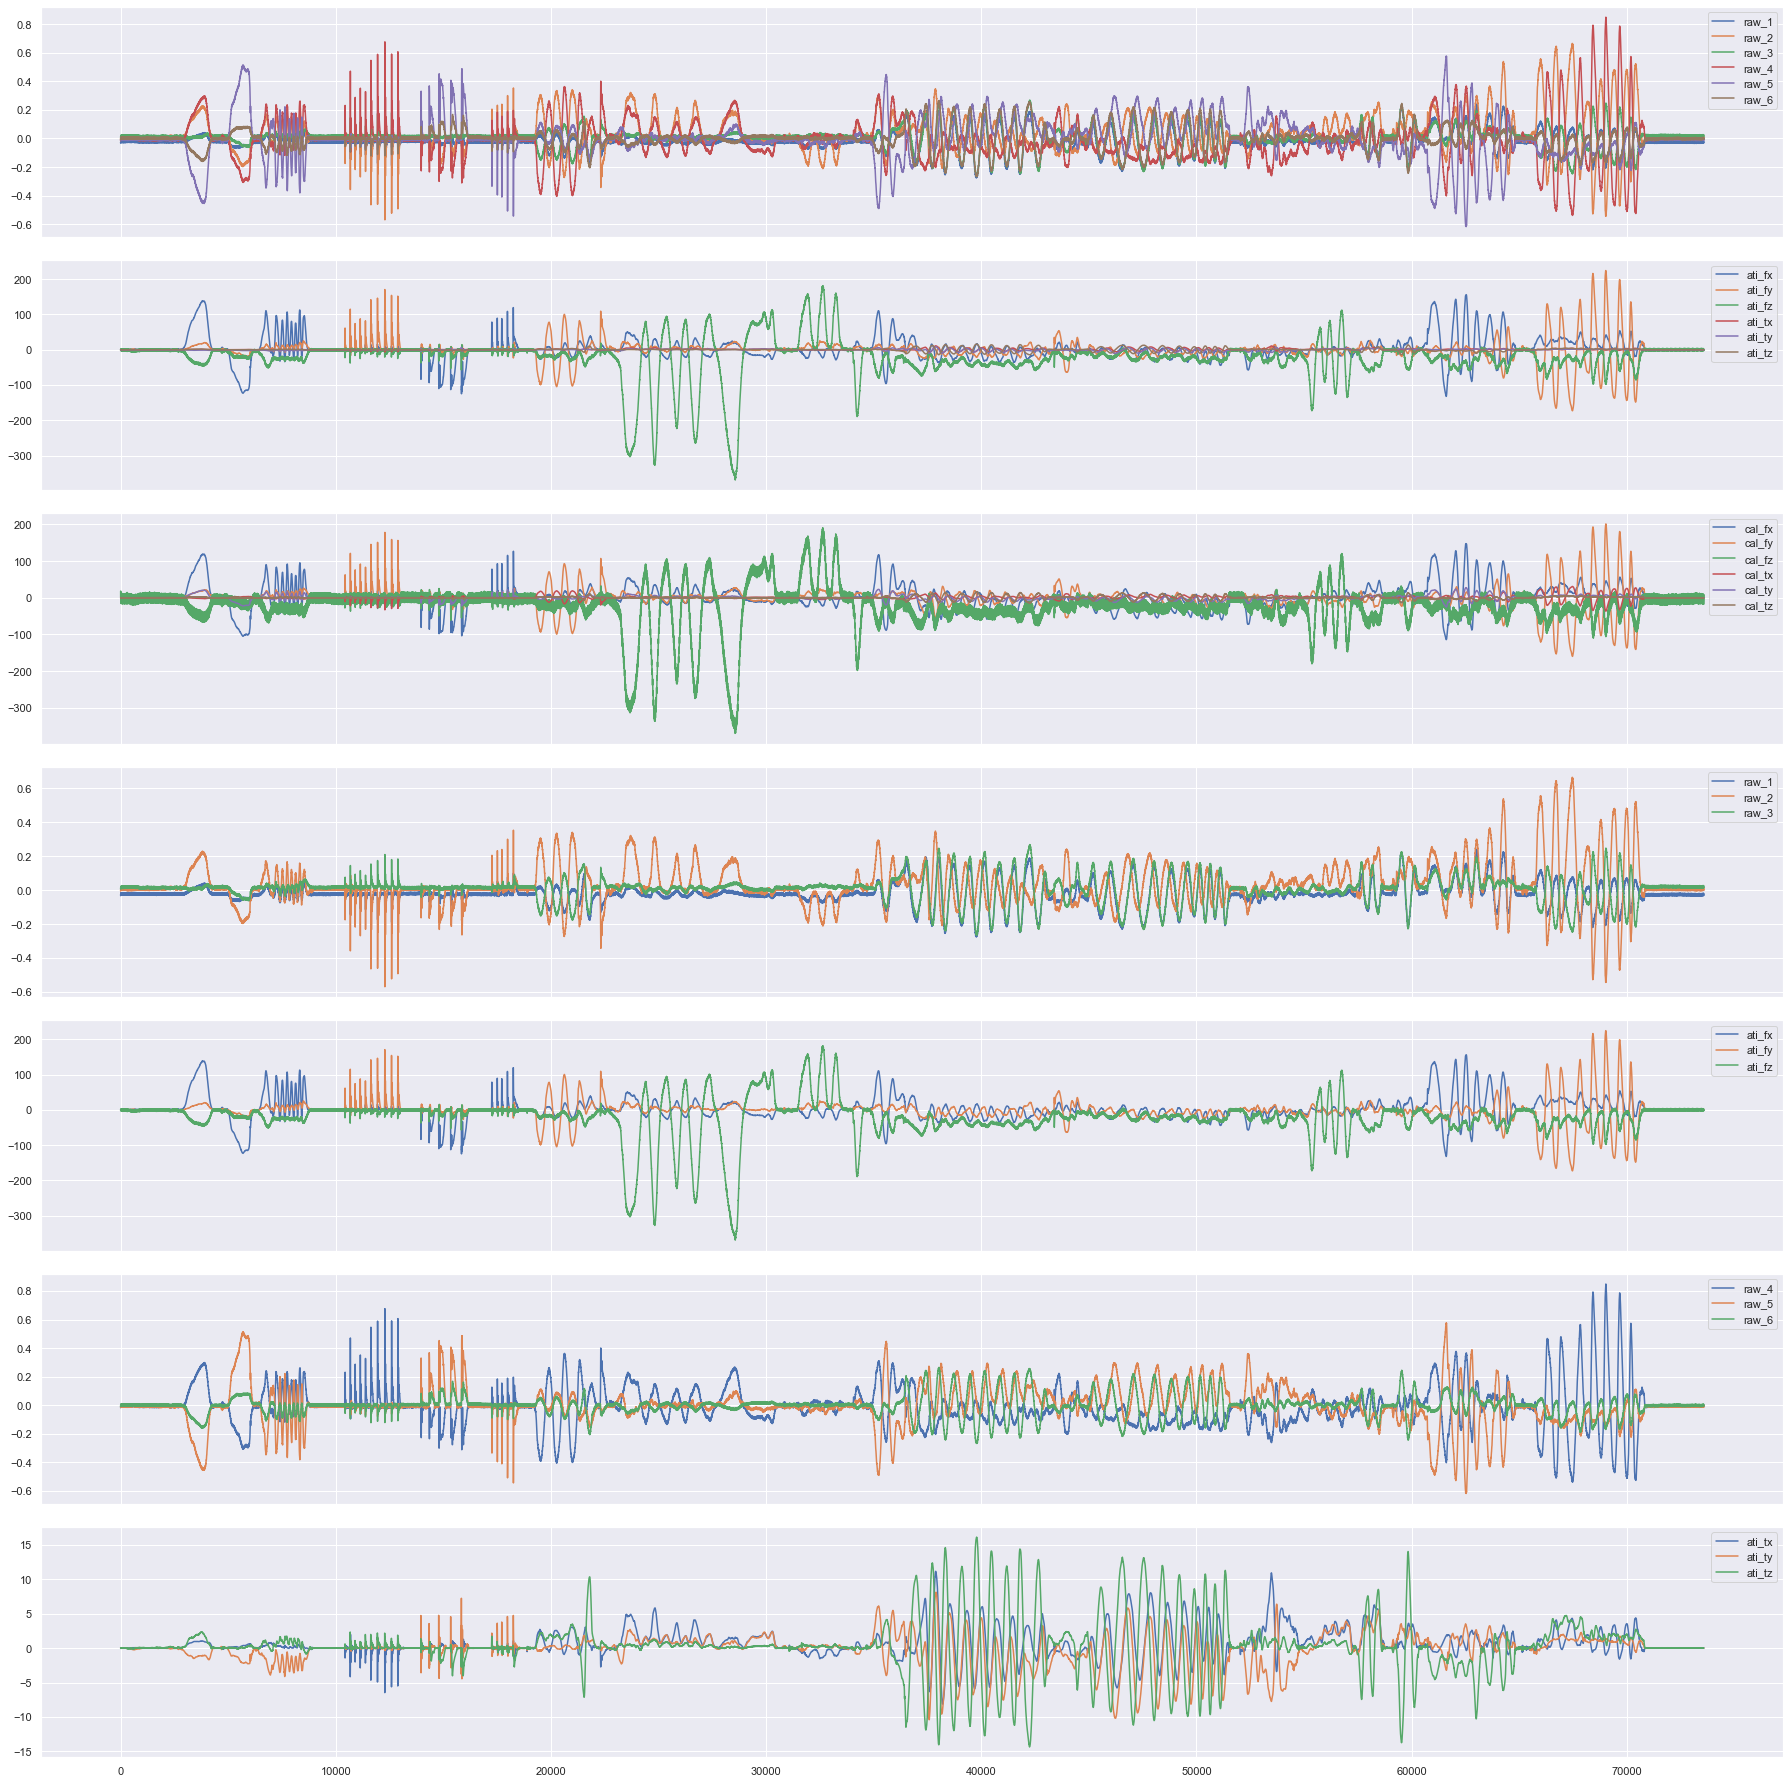

In [32]:

fig, axes = plt.subplots(7,1, sharex='col', figsize=(25,25))
plt.tight_layout()

#data[col_names[1:]].plot(ax=axes[0,0])
data[raw_col_names].plot(ax=axes[0])
data[ati_col_names].plot(ax=axes[1])
data[cal_col_names].plot(ax=axes[2])
data[raw_col_names[:3]].plot(ax=axes[3])
data[ati_col_names[:3]].plot(ax=axes[4])
data[raw_col_names[-3:]].plot(ax=axes[5])
data[ati_col_names[-3:]].plot(ax=axes[6])


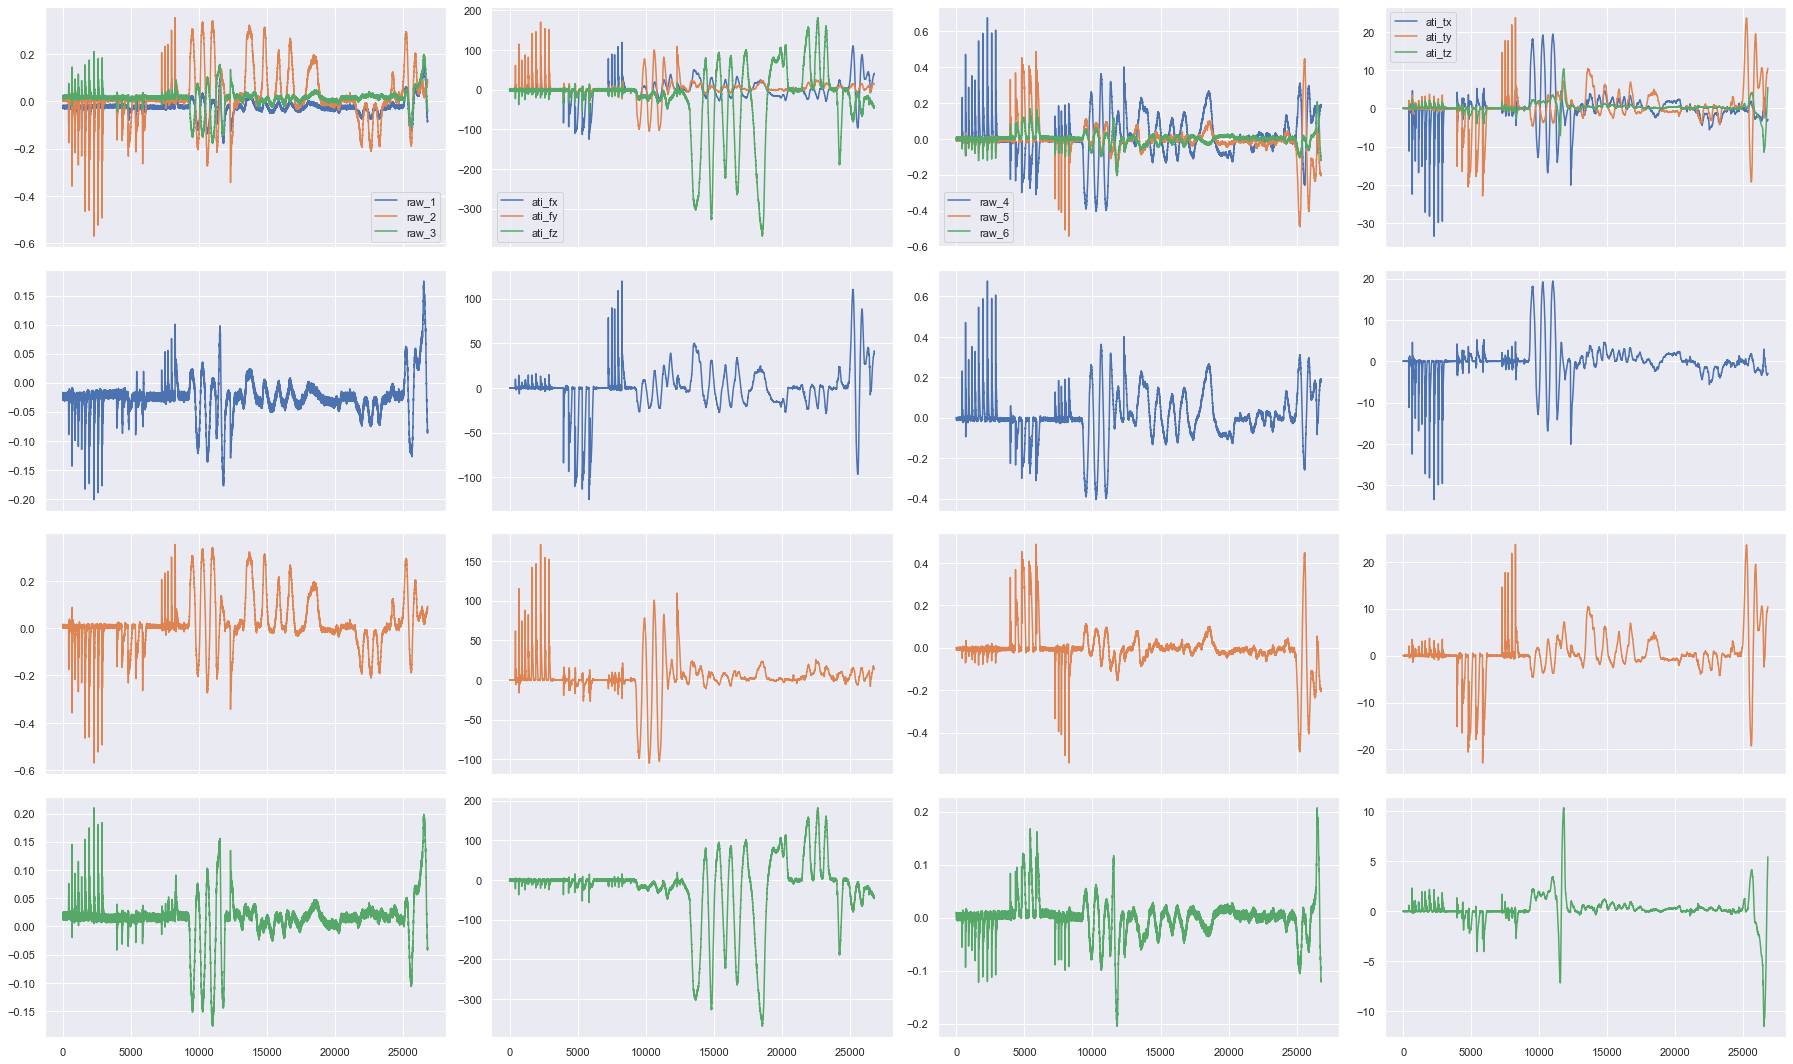

In [25]:
fig, axes = plt.subplots(4,4, sharex='col', figsize=(25,15))
plt.tight_layout()
#https://matplotlib.org/stable/users/dflt_style_changes.html
colors = list(map(lambda x:'C'+str(x),range(10))) 
colors = [f'C{i}' for i in range(10)] 

def plot_data(ax, df, col_names, sub_col):
    df[col_names].plot(ax=axes[0,sub_col])
    for i,c in enumerate(col_names,start=1) :
        df[c].plot(ax=ax[i,sub_col],color=colors[i-1], label=c)
     
plot_data(axes, SGi, raw_col_names[:3],  0)
plot_data(axes, FTi, ati_col_names[:3], 1)
plot_data(axes, SGi, raw_col_names[-3:], 2)
plot_data(axes, FTi, ati_col_names[-3:], 3)

#plot_data(axes, F_residual, ft_col_names[:3], 2)
#plot_data(axes, F_residual, ft_col_names[-3:], 4)


<AxesSubplot:>

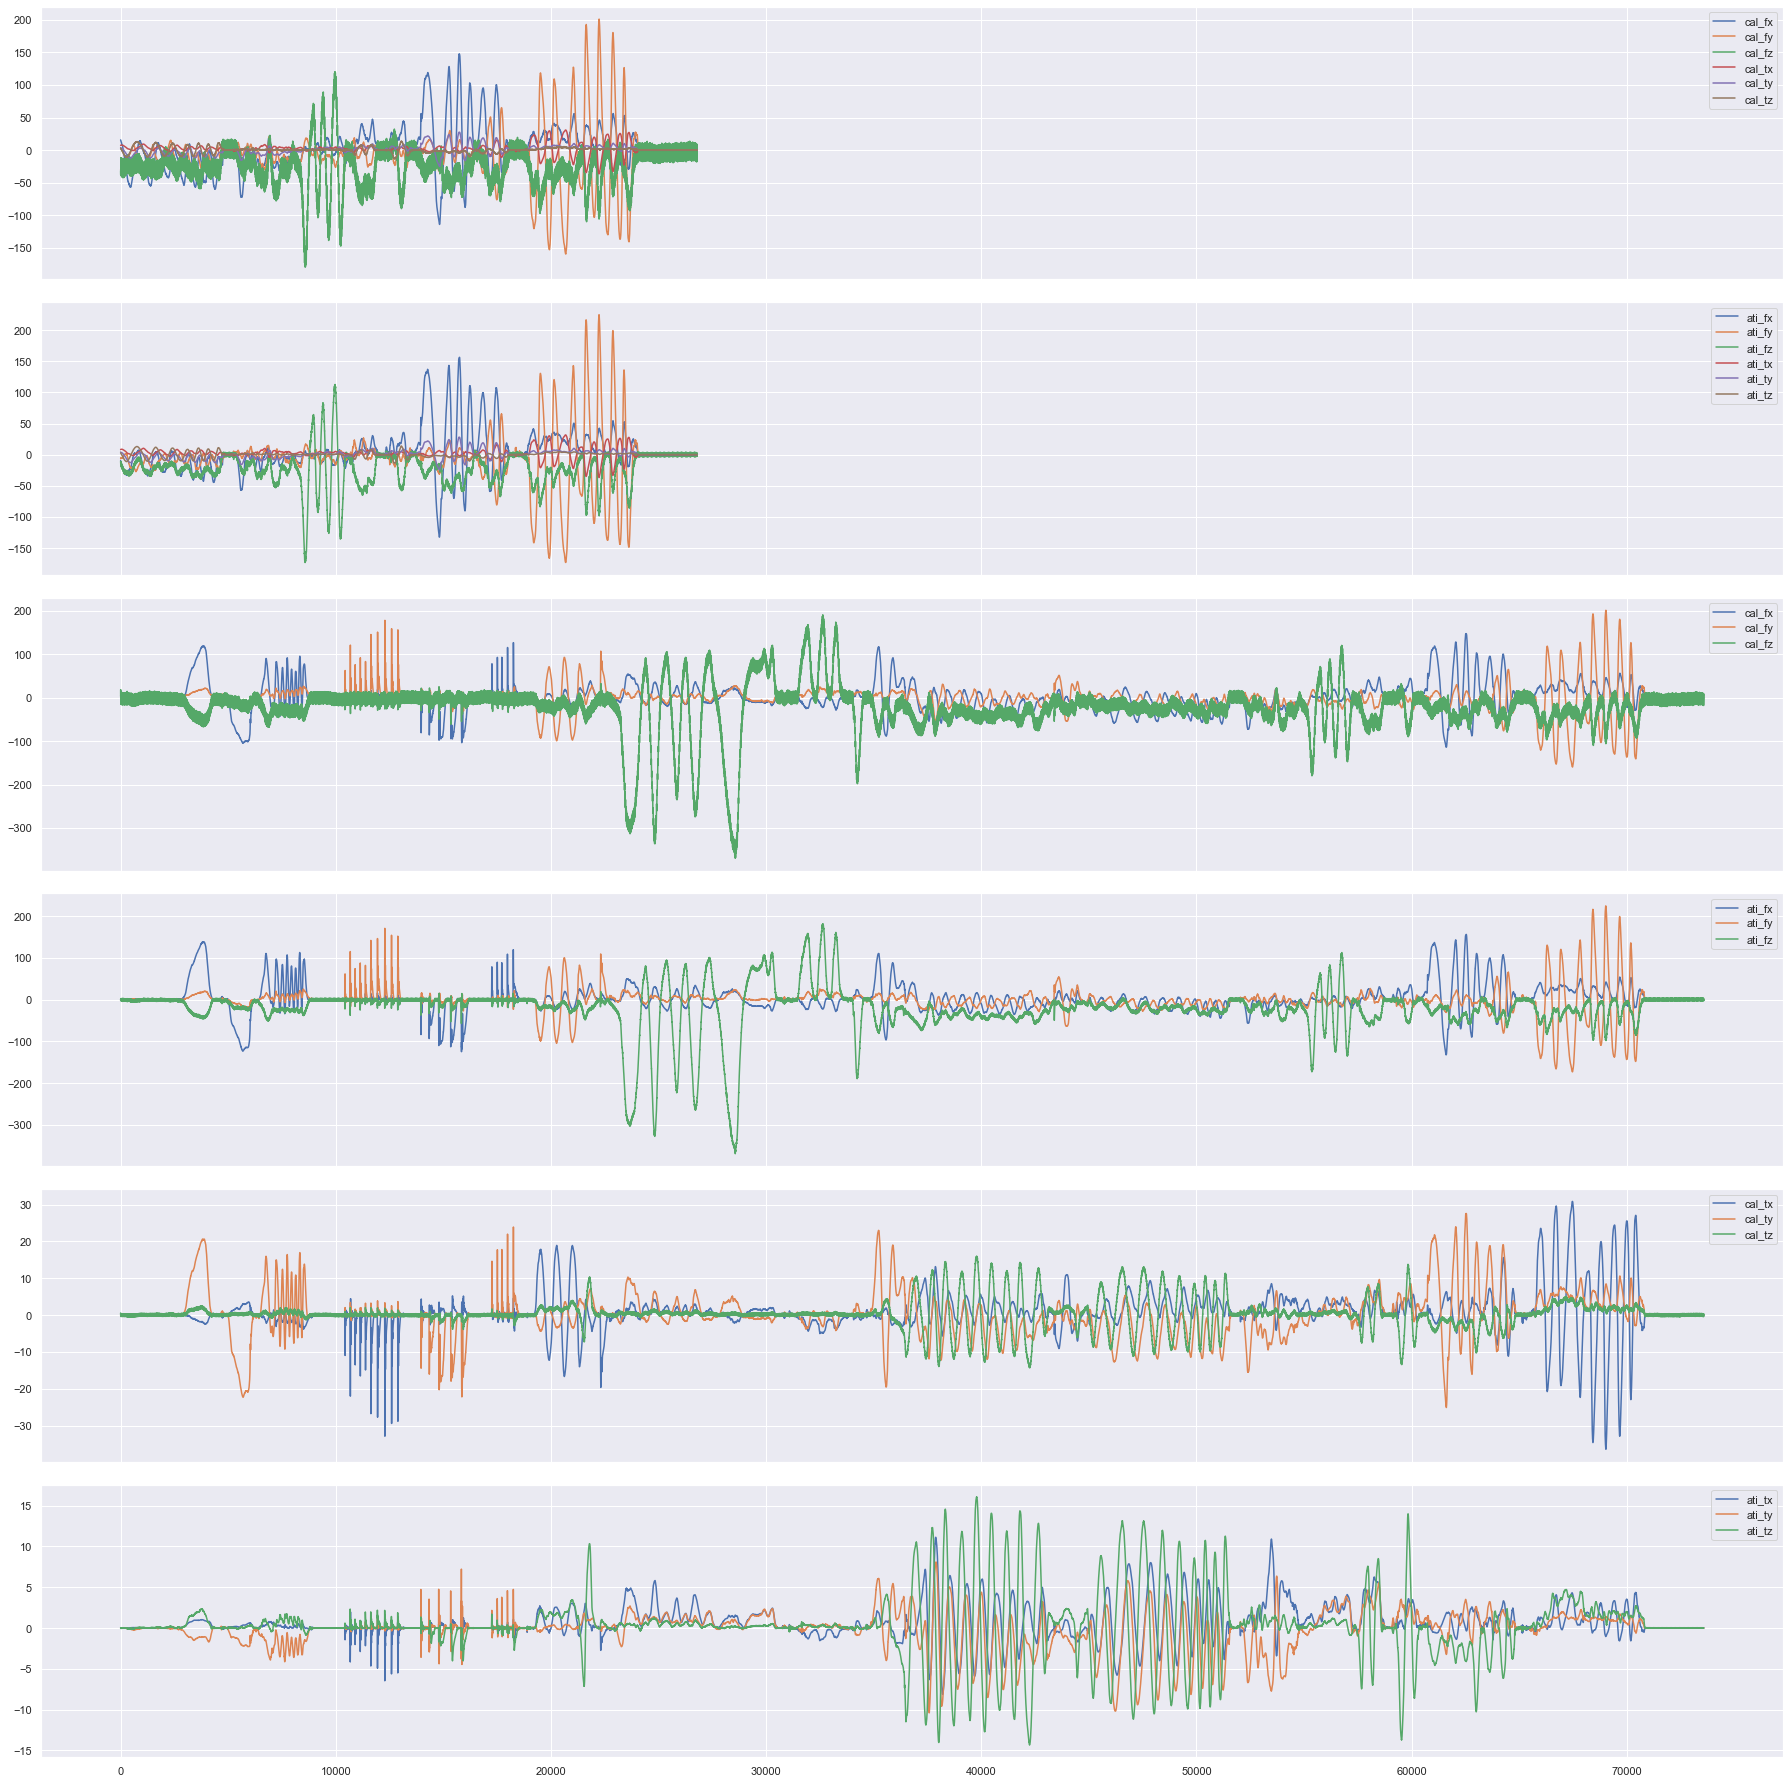

In [33]:
fig, axes = plt.subplots(6,1, sharex='col', figsize=(25,25))
plt.tight_layout()

Fc.plot(ax=axes[0])
FTv.plot(ax=axes[1])
data[cal_col_names[:3]].plot(ax=axes[2])
data[ati_col_names[:3]].plot(ax=axes[3])
data[cal_col_names[-3:]].plot(ax=axes[4])
data[ati_col_names[-3:]].plot(ax=axes[5])


KeyError: 'fx_err'

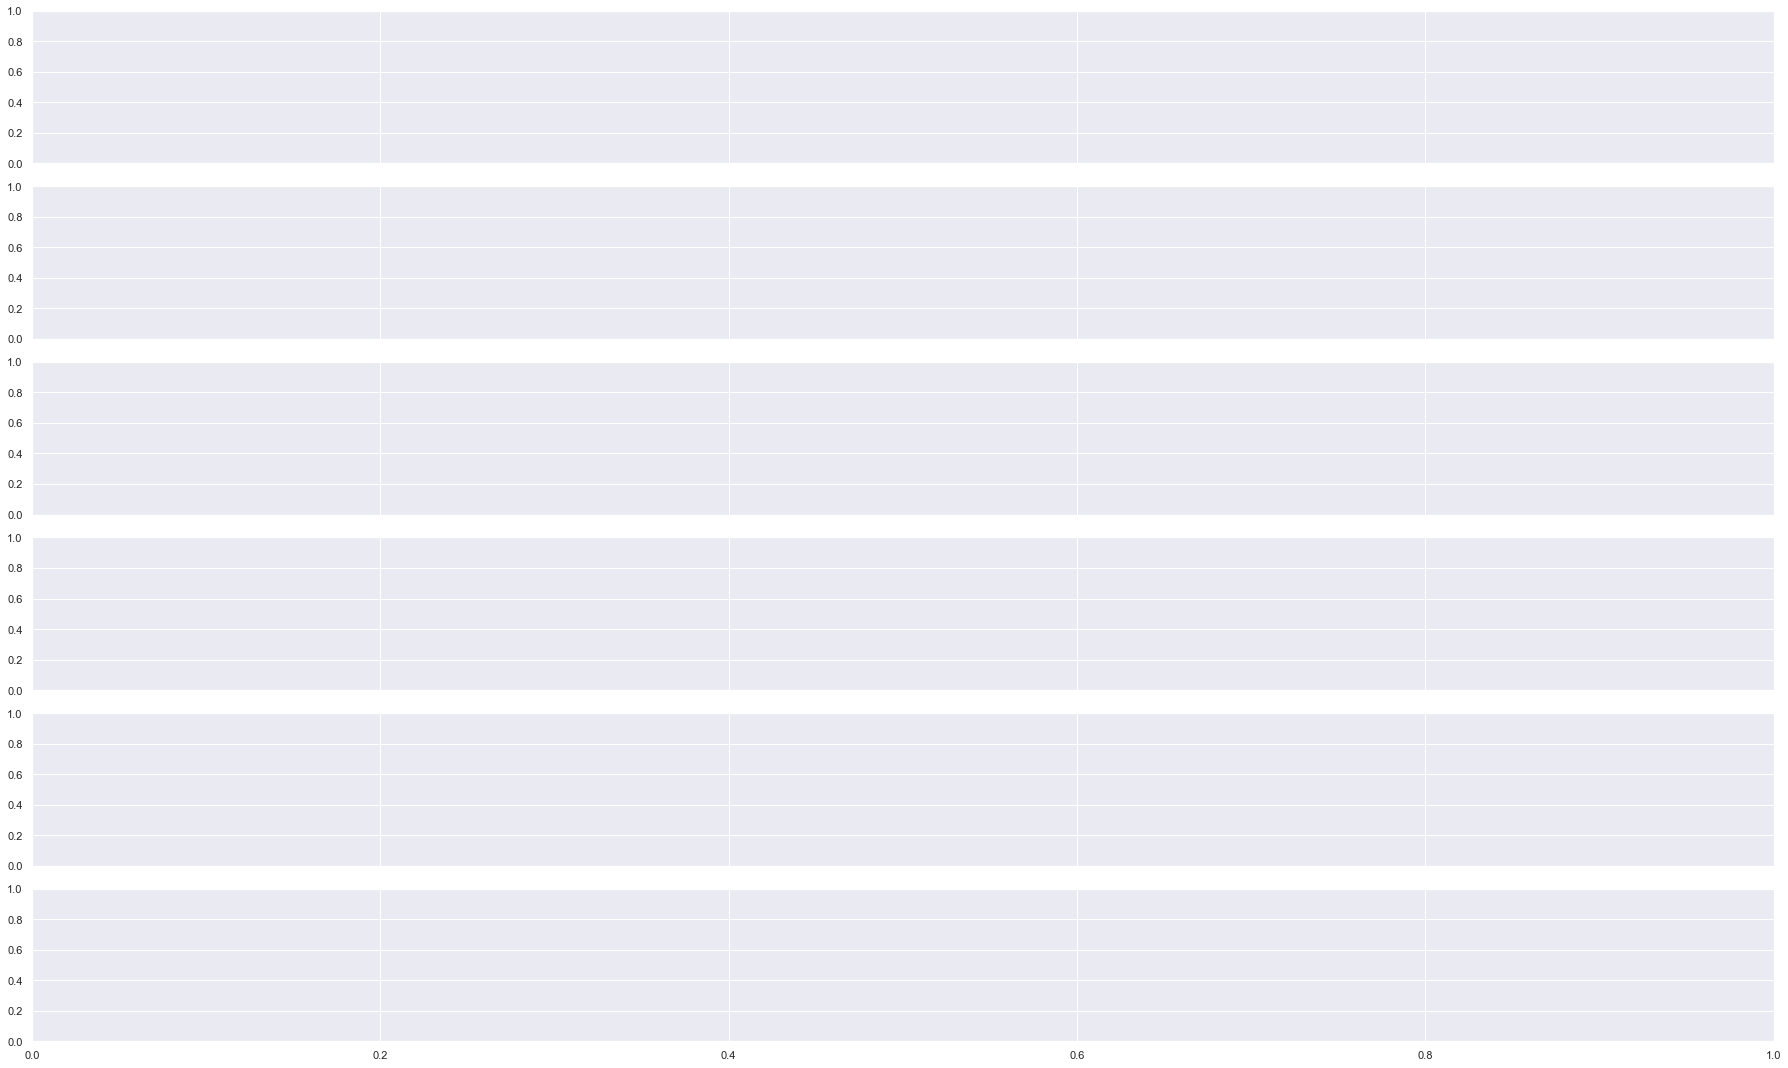

In [34]:
#fig, axes = plt.subplots(6,1, sharex='col', figsize=(25,15))#
#plt.tight_layout()

#F_residual.fx.plot(kind='hist',bins=100)
data["err_fx"].plot()